**中文分词标注在之前的内容中我们有介绍过，常用的是 4-tag(BMES)标注标签，B 表示词的起始位置，M 表示词的中间位置，E 表示词的结束位置，S 表示单字词。分词标注的数据需要对每一个字都进行标注。使用的是微软亚洲研究院开源的数据集(http://sighan.cs.uchicago.edu/bakeoff2005/)**

In [9]:
import re
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, TimeDistributed, Input, Bidirectional
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import json

In [2]:
# 批次大小
batch_size = 256
# 训练周期
epochs = 30
# 词向量长度
embedding_dims = 128
# cell 数量
lstm_cell = 64
# 最长的句子设置为 128，只保留长度小于 128 的句子，最好不要截断句子
# 大部分的句子都是小于 128 长度的
max_length=128

In [3]:
# 读入数据 {b:begin, m:middle, e:end, s:single}，分别代表每个状态代表的是该字在词语中的位置，
# b 代表该字是词语中的起始字，m 代表是词语中的中间字，e 代表是词语中的结束字，s 则代表是单字成词
text = open('msr_train.txt').read()
# 根据换行符切分数据
text = text.split('\n')
# 得到所有的数据和标签
def get_data(s):
    # 匹配形如 a/b 的字符串，其中a和b是两个任意字符。
    s = re.findall('(.)/(.)', s)
    if s:
        s = np.array(s)
        # 返回数据和标签，0 为数据，1 为标签
        return s[:,0],s[:,1]
# 数据
data = []
# 标签
label = []
# 循环每个句子
for s in text:
    # 分离文字和标签
    d = get_data(s)
    if d:
        # 0 为数据
        data.append(d[0])
        # 1 为标签
        label.append(d[1])
    
# 存入 DataFrame
df = pd.DataFrame(index=range(len(data)))
df['data'] = data
df['label'] = label
# 只保留长度小于 max_length 的句子
df = df[df['data'].apply(len) <= max_length]

In [4]:
# 把 data 中所有的 list 都变成字符串格式
texts = [' '.join(x) for x in df['data']]
# 实例化 Tokenizer，设置字典中最大词汇数为 num_words
# Tokenizer 会自动过滤掉一些符号比如：!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n
tokenizer = Tokenizer()
# 传入我们的训练数据，建立词典，词的编号根据词频设定，频率越大，编号越小，
tokenizer.fit_on_texts(texts)
# 把词转换为编号，编号大于 num_words 的词会被过滤掉
sequences = tokenizer.texts_to_sequences(texts)
# 把序列设定为 max_length 的长度，超过 max_length 的部分舍弃，不到 max_length 则补0
# padding='pre'在句子前面进行填充，padding='post'在句子后面进行填充
X = pad_sequences(sequences, maxlen=max_length, padding='post')
# 把 token_config 保存到 json 文件中，模型预测阶段可以使用
file = open('token_config.json','w',encoding='utf-8')
# 把 tokenizer 变成 json 数据
token_config = tokenizer.to_json()
# 保存 json 数据
json.dump(token_config, file)
# 计算字典中词的数量，由于有填充的词，所有加 1
# 中文的单字词数量一般比较少，这个数据集只有 5000 多个词
num_words = len(tokenizer.index_word)+1

In [5]:
# 相当于是把字符类型的标签变成了数字类型的标签
tag = {'o':0, 's':1, 'b':2, 'm':3, 'e':4}
Y = []
# 循环原来的标签
for label in df['label']:
    temp = []
    # 把 osbme 转变成 01234
    temp = temp + [tag[l] for l in label]
    # 在列表末尾用0进行填充，使其长度达到max_length，保证维度的一致性
    temp = temp + [0]*(max_length-len(temp))
    Y.append(temp)
Y = np.array(Y)

In [6]:
# 切分数据集
x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.2)

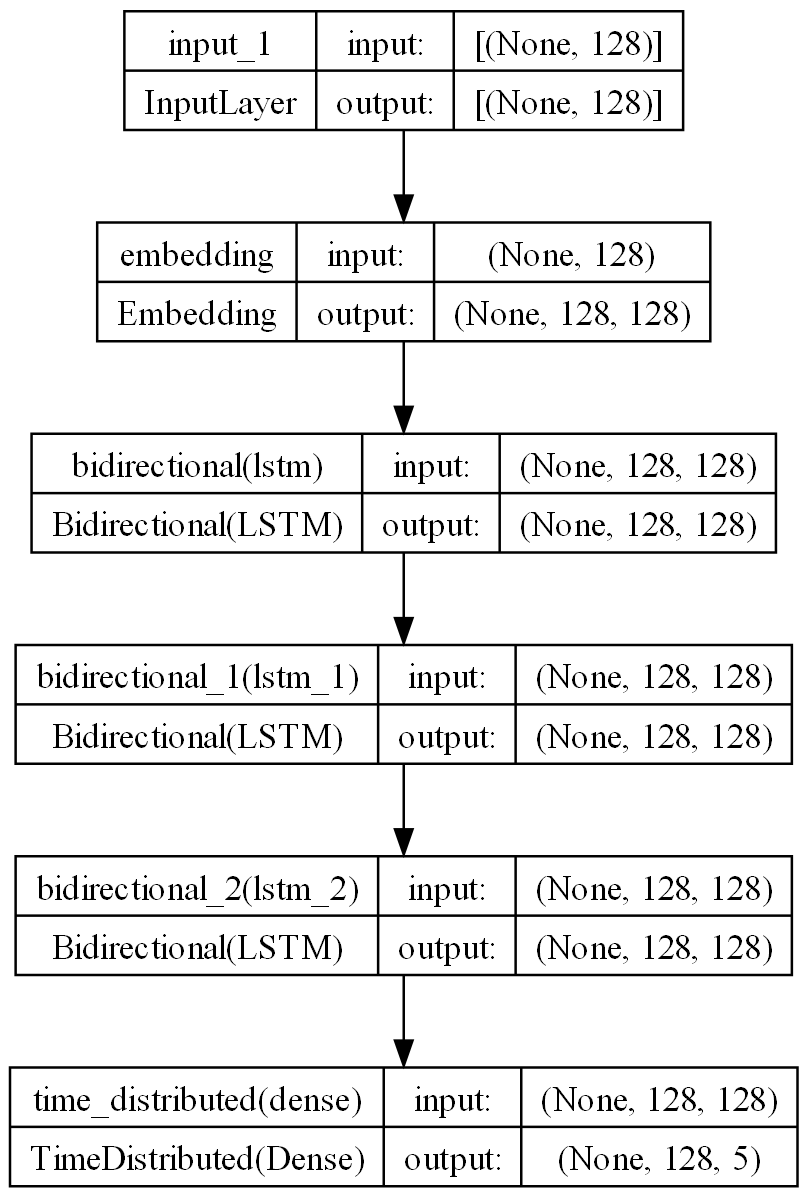

In [7]:
# 定义模型
sequence_input = Input(shape=(max_length))
# Embedding 层，
# mask_zero=True，计算时忽略 0 值，也就是填充的数据不参与计算
embedding_layer = Embedding(num_words, embedding_dims, mask_zero=True)(sequence_input)
# 双向 LSTM，因为我们的任务是分词标签，因此需要 LSTM 每个序列的 Hidden State 输出值
# return_sequences=True 表示返回所有序列 LSTM 的输出，默认只返回最后一个序列LSTM 的输出
x = Bidirectional(LSTM(lstm_cell, return_sequences=True))(embedding_layer)
# 堆叠多个双向 LSTM
x = Bidirectional(LSTM(lstm_cell, return_sequences=True))(x)
x = Bidirectional(LSTM(lstm_cell, return_sequences=True))(x)
# TimeDistributed 该包装器可以把一个层应用到输入的每一个时间步上
# 也就是说 LSTM 每个序列输出的 Hidden State 都应该连接一个 Dense 层并预测出 5 个结果
# 这 5 个结果分别对应：sbmeo。o 为填充值，对应标签 0。
preds = TimeDistributed(Dense(5, activation='softmax'))(x)
# 定义模型输入输出
model = Model(inputs=sequence_input, outputs=preds)
# 画图
plot_model(model, show_shapes=True, dpi=180)

In [8]:
# 定义代价函数，优化器
# 使用 sparse_categorical_crossentropy，标签不需要转变为独热编码 one-hot
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# 训练模型
model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test))
# 保存模型
model.save('lstm_tag.h5')

Epoch 1/30
268/268 [==============================] - 53s 123ms/step - loss: 0.2744 - accuracy: 0.6474 - val_loss: 0.1408 - val_accuracy: 0.8536
Epoch 2/30
268/268 [==============================] - 28s 105ms/step - loss: 0.1246 - accuracy: 0.8710 - val_loss: 0.1168 - val_accuracy: 0.8792
Epoch 3/30
268/268 [==============================] - 29s 107ms/step - loss: 0.1054 - accuracy: 0.8919 - val_loss: 0.1025 - val_accuracy: 0.8955
Epoch 4/30
268/268 [==============================] - 30s 113ms/step - loss: 0.0931 - accuracy: 0.9056 - val_loss: 0.0958 - val_accuracy: 0.9029
Epoch 5/30
268/268 [==============================] - 31s 117ms/step - loss: 0.0833 - accuracy: 0.9158 - val_loss: 0.0850 - val_accuracy: 0.9142
Epoch 6/30
268/268 [==============================] - 30s 114ms/step - loss: 0.0746 - accuracy: 0.9248 - val_loss: 0.0780 - val_accuracy: 0.9217
Epoch 7/30
268/268 [==============================] - 31s 117ms/step - loss: 0.0671 - accuracy: 0.9328 - val_loss: 0.0733 - val_ac

# 使用模型进行分词

In [10]:
# 载入 tokenizer
json_file = open('token_config.json','r',encoding='utf-8')
token_config = json.load(json_file)
tokenizer = tokenizer_from_json(token_config)
# 获得字典，键为字，值为编号
word_index = tokenizer.word_index
# 载入模型
model = load_model('lstm_tag.h5')
# 载入数据集做处理主要是为了计算状态转移概率
# 读入数据
text = open('msr_train.txt', encoding='gb18030').read()
# 根据换行符切分数据
text = text.split('\n')

# 数据
data = []
# 标签
label = []
# 循环每个句子
for s in text:
    # 分离文字和标签
    d = get_data(s)
    if d:
        # 0 为数据
        data.append(d[0])
        # 1 为标签
        label.append(d[1])

In [11]:
def ngrams(texts, MIN_N, MAX_N):
    """
    计算文本数据中的N-grams词汇组合的出现次数。
比如 ngrams(texts,2,2)，只计算 2-grams   ngrams(texts,2,4)，计算 2-grams，3-grams，4-grams
    参数:
    texts (list): 二维列表，每行表示一个句子，每个句子是由词汇组成的列表。
    MIN_N (int): 最小的N-grams的N值，表示N-grams的最小长度。
    MAX_N (int): 最大的N-grams的N值，表示N-grams的最大长度。

    返回:
    ngrams_dict (dict): 字典，记录N-grams词汇组合和其出现次数。
                       键是N-grams词汇组合的字符串表示，值是对应的出现次数。
    """
    # 定义空字典记录
    ngrams_dict = {}
    # 循环每一个句子
    for tokens in texts:
        # 计算一个句子 token 数量
        n_tokens = len(tokens)
        # 词汇组合统计
        for i in range(n_tokens):
            for j in range(i+MIN_N, min(n_tokens, i+MAX_N)+1):
                # 词汇组合 list 转字符串
                temp = ''.join(tokens[i:j])
                # 字典计数加一
                ngrams_dict[temp] = ngrams_dict.get(temp, 0) + 1
    # 返回字典
    return ngrams_dict

# 统计状态转移次数
ngrams_dict = ngrams(label,2,2)
print(ngrams_dict)

{'sb': 600115, 'be': 1039906, 'es': 659674, 'ss': 427204, 'bm': 215149, 'me': 215149, 'mm': 211874, 'eb': 594480}


In [13]:
# 计算状态转移总次数
sum_num = 0
for value in ngrams_dict.values():
    sum_num = sum_num + value
# 计算状态转移概率
p_sb = ngrams_dict['sb']/sum_num
p_be = ngrams_dict['be']/sum_num
p_es = ngrams_dict['es']/sum_num
p_ss = ngrams_dict['ss']/sum_num
p_bm = ngrams_dict['bm']/sum_num
p_me = ngrams_dict['me']/sum_num
p_mm = ngrams_dict['mm']/sum_num
p_eb = ngrams_dict['eb']/sum_num
# p_oo 用于表示不可能的转移，-np.inf 负无穷
p_oo = -np.inf

In [14]:
# 使用条件随机场 CRF 来计算转移矩阵有可能效果会更好。这里用简单的二元模型来定义状态转移矩阵
# 其中o 为填充状态，跟 o 相关的转移也都不需要考虑
transition_params = [[p_oo,p_oo,p_oo,p_oo,p_oo],
                     [p_oo,p_ss,p_sb,p_oo,p_oo],
                     [p_oo,p_oo,p_oo,p_bm,p_be],
                     [p_oo,p_oo,p_oo,p_mm,p_me],
                     [p_oo,p_es,p_eb,p_oo,p_oo]]

In [20]:
# 维特比算法
def viterbi_decode(sequence, transition_params):
    """
    Args:
    sequence: 一个[seq_len, num_tags]矩阵，观测序列
    transition_params: 一个[num_tags, num_tags]矩阵
    Returns:
    viterbi: 一个[seq_len]序列
    """
    # 假设状态转移共有 num_tags 种状态，其中num_tags表示隐藏状态的数量
    # 创建一个跟 sequence 相同形状的网格
    score = np.zeros_like(sequence)
    # 创建一个跟 sequence 相同形状的 path，用于记录路径
    path = np.zeros_like(sequence, dtype=np.int32)
    # 起始分数
    score[0] = sequence[0]
    for t in range(1, sequence.shape[0]):
        # t-1 时刻 score 得分加上 trans 分数，得到下一时刻所有状态转移[num_tags, num_tags]的得分
        T = np.expand_dims(score[t - 1], 1) + transition_params
        # t 时刻 score = 计算每个状态转移的最大得分 + 下个序列预测得分
        score[t] = np.max(T, 0) + sequence[t]
        # 记录每个状态转移的最大得分所在位置
        path[t] = np.argmax(T, 0)
    # score[-1]为最后得到的 num_tags 种状态得分
    viterbi = [np.argmax(score[-1])]  # 找到最高分数所在位置
    # 回头确定来的路径，相当于知道最高分以后从后往前走
    for p in reversed(path[1:]):
        viterbi.append(p[viterbi[-1]])
    # 反转 viterbi 列表，把 viterbi 变成正向路径
    viterbi.reverse()
    # 计算最大得分，如果需要可以 return
    # viterbi_score = np.max(score[-1])
    return viterbi

In [21]:
# 小句分词函数
def cut(sentence):
    # 如果句子大于最大长度，只取 max_length 个词
    if len(sentence) >= max_length:
        seq = sentence[:max_length]
    # 如果不足 max_length，则填充
    else:
        seq = []
        for s in sentence:
            try:
                # 在字典里查询编号
                seq.append(word_index[s])
            except:
                # 如果不在字典里填充 0
                seq.append(0)
        seq = seq + [0]*(max_length-len(sentence))
    # 获得预测结果，shape(32,5)
    preds = model.predict([seq])[0]
    # 维特比算法
    viterbi = viterbi_decode(preds, transition_params)
    # 只保留跟句子相同长度的分词标注
    y = viterbi[:len(sentence)]
    # 分词
    words = []
    for i in range(len(sentence)):
        # 如果标签为 s 或 b，append 到结果的 list 中
        if y[i] in [1, 2]:
            words.append(sentence[i])
        else:
        # 如果标签为 m 或 e，在 list 最后一个元素中追加内容
            words[-1] += sentence[i]
    return words

In [17]:
# 根据符号断句
cuts = re.compile(u'([\da-zA-Z ]+)|[。，、？！\.\?,!()（）]')

In [22]:
# 先分小句，再对小句分词
def cut_word(s):
    result = []
    # 指针设置为 0
    i = 0
    # 根据符号断句
    for c in cuts.finditer(s):
        # 对符号前的部分分词
        result.extend(cut(s[i:c.start()]))
        # 加入符号
        result.append(s[c.start():c.end()])
        # 移动指针到符号后面
        i = c.end()
    # 对最后的部分进行分词
    result.extend(cut(s[i:]))
    return result

In [27]:
print(cut_word('我们没有永恒的朋友，也没有永恒的敌人，只有永恒的利益。 --亨利·坦普尔'))

1/1 [==============================] - 0s 213ms/step
['我们', '没有', '永恒', '的', '朋友', '，', '也', '没有', '永恒', '的', '敌人', '，', '只有', '永恒', '的', '利益', '。', ' ', '--', '亨利·坦普尔']


In [28]:
print(cut_word ('后来，错过也成了人间常态。 --网易云音乐'))

1/1 [==============================] - 0s 213ms/step
['后来', '，', '错过', '也', '成', '了', '人间', '常态', '。', ' ', '--', '网易云', '音乐']
